In [ ]:
import csv
import glob
import json
import os
import re
from base64 import b64encode
from collections import defaultdict
from hashlib import sha256
from time import time
from typing import Any, Dict, Iterable, Iterator, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from matplotlib.ticker import FuncFormatter

BASE = "https://www.quantconnect.com/api/v2"
USER_ID = 123456
API_TOKEN = "key here"
PROJECT_ID = 123456
OUTPUT_DIR = "/content/drive/MyDrive/AlgoA2/Test Result"
SAVE_ALL_BACKTESTS = True


In [2]:

def headers() -> Dict[str, str]:
    '''QuantConnect API headers with signature timestamp.'''
    timestamp = str(int(time()))
    signature = sha256(f"{API_TOKEN}:{timestamp}".encode()).hexdigest()
    auth = b64encode(f"{USER_ID}:{signature}".encode()).decode()
    return {"Authorization": f"Basic {auth}", "Timestamp": timestamp}


def qc_post(endpoint: str, payload: Dict[str, Any]) -> Dict[str, Any]:
    '''POST to the QC API and return the JSON payload.'''
    response = requests.post(
        f"{BASE}/{endpoint}",
        headers=headers(),
        json=payload,
    )
    response.raise_for_status()
    data = response.json()
    if not data.get("success", True):
        raise RuntimeError(data.get("errors") or f"QC API error: {endpoint}")
    return data


def list_projects(limit: int = 20) -> list[dict]:
    '''Fetch recent projects for quick inspection.'''
    data = qc_post("projects/read", {})
    projects = data.get("projects", [])
    projects.sort(
        key=lambda project: project.get("modified", ""),
        reverse=True,
    )
    return projects[:limit]


def _normalize_key(value: str) -> str:
    return "".join(
        character.lower() for character in value if character.isalnum()
    )


def _to_float(value: Any) -> Optional[float]:
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    cleaned = str(value).replace("%", "").replace(",", "").strip()
    try:
        return float(cleaned)
    except ValueError:
        match = re.search(r"-?\d+(?:\.\d+)?", cleaned)
        return float(match.group(0)) if match else None


def _to_int(value: Any) -> Optional[int]:
    if value is None:
        return None
    if isinstance(value, bool):
        return int(value)
    if isinstance(value, (int, float)):
        return int(round(value))
    match = re.search(r"-?\d+", str(value))
    return int(match.group(0)) if match else None


def _to_mapping(obj: Any) -> Dict[str, Any]:
    '''Turn QC list/dict shapes into a plain mapping.'''
    if isinstance(obj, dict):
        return {
            str(item_key): item_value
            for item_key, item_value in obj.items()
        }
    mapping: Dict[str, Any] = {}
    if isinstance(obj, list):
        for item in obj:
            if isinstance(item, dict):
                key = (
                    item.get("name")
                    or item.get("key")
                    or item.get("metric")
                    or item.get("statistic")
                    or item.get("Name")
                    or item.get("Key")
                )
                value = (
                    item.get("value")
                    or item.get("val")
                    or item.get("number")
                    or item.get("score")
                    or item.get("Value")
                )
                if key is not None:
                    mapping[str(key)] = value
            elif isinstance(item, (list, tuple)) and len(item) >= 2:
                item_key, item_value = item[0], item[1]
                if item_key is not None:
                    mapping[str(item_key)] = item_value
    return mapping


def normalize_statistics(stats_obj: Any) -> Dict[str, Any]:
    raw_mapping = _to_mapping(stats_obj)
    return {
        stat_key: _to_float(stat_value)
        if isinstance(stat_value, (int, float, str))
        else stat_value
        for stat_key, stat_value in raw_mapping.items()
    }


def normalize_parameters(params_obj: Any) -> Dict[str, Any]:
    return _to_mapping(params_obj)


def iter_backtests(
    opt_obj: Dict[str, Any]
) -> Iterator[Tuple[Optional[str], Dict[str, Any]]]:
    """Yield (backtest_id, backtest_dict) from list or dict payloads."""
    container = opt_obj.get("backtests") or {}
    if isinstance(container, dict):
        for backtest_id, payload in container.items():
            yield backtest_id, payload
    elif isinstance(container, list):
        for payload in container:
            backtest_id = (
                payload.get("backtestId")
                or payload.get("id")
                or payload.get("backtestid")
            )
            yield backtest_id, payload


In [ ]:
def build_opt_base_from_name(name: str) -> str:
    """Convert 'EMA with ATR with IWM' into 'EMA_WITH_ATR_WITH_IWM'."""
    if not name:
        return "STRATEGY"
    tokens = re.findall(r"[A-Za-z0-9]+", name)
    parts = [
        token.lower() if token.lower() == "with" else token.upper()
        for token in tokens
    ]
    return re.sub(r"_+", "_", "_".join(parts)).strip("_")


def extract_backtest_shift_months(
    backtest: Dict[str, Any],
    meta: Optional[Dict[str, Any]] = None,
) -> Optional[int]:
    params = (
        backtest.get("parameterSet")
        or backtest.get("parameters")
        or (meta and meta.get("bestParams"))
        or {}
    )
    normalized_params = {
        _normalize_key(param_key): param_value
        for param_key, param_value in normalize_parameters(params).items()
    }
    for key in (
        "backtestshiftmonths",
        "shiftmonths",
        "backtestshiftmonth",
        "shiftmonth",
        "backtestshift",
        "shift",
        "months",
    ):
        if key in normalized_params:
            return _to_int(normalized_params[key])
    return None


def list_optimizations(project_id: int, limit: int = 20) -> list[dict]:
    payload = {"projectId": project_id}
    data = qc_post("optimizations/list", payload)
    optimizations = data.get("optimizations", [])
    optimizations.sort(
        key=lambda optimization: optimization.get("created", ""),
        reverse=True,
    )
    return optimizations[:limit]


def read_optimization(optimization_id: str) -> Dict[str, Any]:
    payload = {"optimizationId": optimization_id}
    data = qc_post("optimizations/read", payload)
    return data["optimization"]


def read_backtest(project_id: int, backtest_id: str) -> Dict[str, Any]:
    payload = {"projectId": project_id, "backtestId": backtest_id}
    data = qc_post("backtests/read", payload)
    return data["backtest"]


def safe_name(value: str) -> str:
    return re.sub(r"[^A-Za-z0-9._-]+", "-", value)


def pick_best_backtest(opt_obj: Dict[str, Any]) -> Optional[Dict[str, Any]]:
    criterion = opt_obj.get("criterion") or {}
    target = criterion.get("target") or opt_obj.get("optimizationTarget")
    extremum = (criterion.get("extremum") or "max").lower()
    norm_token = _normalize_key(target or "")
    want_max = extremum != "min"

    best_id: Optional[str] = None
    best_score: Optional[float] = None
    best_params: Optional[Dict[str, Any]] = None

    for backtest_id, backtest in iter_backtests(opt_obj):
        stats = normalize_statistics(backtest.get("statistics") or {})
        normalized_stats = {
            _normalize_key(stat_key): stat_value
            for stat_key, stat_value in stats.items()
        }
        candidates = [
            norm_token,
            norm_token.replace("ratio", "rati"),
            norm_token + "ratio",
            norm_token.replace("ratio", " ratio"),
        ]
        score = next(
            (
                normalized_stats[candidate_token]
                for candidate_token in candidates
                if candidate_token in normalized_stats
                and isinstance(normalized_stats[candidate_token], (int, float))
            ),
            None,
        )
        if score is None:
            for key, value in normalized_stats.items():
                if (
                    norm_token
                    and norm_token in key
                    and isinstance(value, (int, float))
                ):
                    score = value
                    break
        if score is None:
            continue
        if (
            best_score is None
            or (want_max and score > best_score)
            or (not want_max and score < best_score)
        ):
            best_score = score
            best_id = backtest_id
            best_params = normalize_parameters(
                backtest.get("parameterSet")
                or backtest.get("parameters")
                or {}
            )

    if best_id is None:
        return None
    return {
        "backtestId": best_id,
        "score": best_score,
        "parameters": best_params,
        "targetToken": target,
        "extremum": extremum,
    }


def save_key_stats_json(
    optimization_id: str,
    backtest: Dict[str, Any],
    meta: Dict[str, Any],
    base_name: str,
    suffix: int,
) -> str:
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # The backtest_payload is the detailed object.
    full_data_to_save = backtest.copy()

    # Add the extra metadata from the optimization
    full_data_to_save["optimizationId"] = optimization_id
    full_data_to_save["projectId"] = PROJECT_ID
    full_data_to_save["optimizationTarget"] = meta.get("target")
    full_data_to_save["optimizationExtremum"] = meta.get("extremum")

    # Also, let's normalize the stats and add them
    stats_raw = backtest.get("statistics") or backtest.get("stats") or {}
    stats_norm = normalize_statistics(stats_raw)  # helper function
    full_data_to_save["statistics_normalized"] = stats_norm

    # Define the filename
    filename = (
        os.path.join(OUTPUT_DIR, safe_name(f"{base_name}_{suffix}")) + ".json"
    )

    # Save the entire modified object
    with open(filename, "w", encoding="utf-8") as handle:
        json.dump(full_data_to_save, handle, indent=2)
    return filename


print(f"Fetching last optimizations for project {PROJECT_ID}...")
optimizations = list_optimizations(PROJECT_ID)
results: list[dict] = []

for opt in optimizations:
    optimization_id = opt.get("optimizationId") or opt.get("id")
    detail = read_optimization(optimization_id)
    best = pick_best_backtest(detail)

    summary = {
        "optimizationId": optimization_id,
        "name": opt.get("name"),
        "created": opt.get("created"),
        "status": opt.get("status"),
        "target": (detail.get("criterion") or {}).get("target")
        or detail.get("optimizationTarget"),
        "extremum": (detail.get("criterion") or {}).get("extremum") or "max",
        "bestBacktestId": best and best["backtestId"],
        "bestScore": best and best["score"],
        "bestParams": best and best["parameters"],
    }
    results.append(summary)

    base_name = build_opt_base_from_name(summary["name"] or "")

    if SAVE_ALL_BACKTESTS:
        backtests = list(iter_backtests(detail))
        full_payloads: list[Tuple[Optional[int], str, Dict[str, Any]]] = []
        for backtest_id, _unused_payload in backtests:
            backtest = read_backtest(PROJECT_ID, backtest_id)
            shift = extract_backtest_shift_months(backtest, summary)
            full_payloads.append((shift, backtest_id, backtest))

        missing = [
            row_index
            for row_index, (shift, _unused_id, _unused_payload) in enumerate(
                full_payloads
            )
            if shift is None
        ]
        if missing:
            total = len(full_payloads)
            candidates = list(range(total - 1, -1, -1))
            used_shifts = {
                shift
                for shift, _unused_id, _unused_payload in full_payloads
                if isinstance(shift, int)
            }
            available_shifts = [
                value for value in candidates if value not in used_shifts
            ]
            for missing_index in missing:
                assigned_shift = (
                    available_shifts.pop(0) if available_shifts else 0
                )
                shift, backtest_id, payload = full_payloads[missing_index]
                full_payloads[missing_index] = (
                    assigned_shift,
                    backtest_id,
                    payload,
                )

        full_payloads.sort(
            key=lambda item: (
                item[0] is None,
                -(item[0] if item[0] is not None else -1),
            )
        )
        for shift, _unused_backtest_id, payload in full_payloads:
            suffix = shift if shift is not None else -1
            filename = save_key_stats_json(
                optimization_id, payload, summary, base_name, suffix
            )
            print(f"Saved: {filename}")
    else:
        if summary["bestBacktestId"]:
            backtest = read_backtest(PROJECT_ID, summary["bestBacktestId"])
            shift = extract_backtest_shift_months(backtest, summary) or 0
            filename = save_key_stats_json(
                optimization_id, backtest, summary, base_name, shift
            )
            print(f"Saved best backtest: {filename}")


Fetching last optimizations for project 25542078...
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_11.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_10.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_9.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_8.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_7.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_6.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_5.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_4.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_3.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_2.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FILTER_ONLY_with_RWM_1.json
Saved: /content/drive/MyDrive/AlgoA2/Test Result/RSI_FI

In [4]:
def parse_shift_from_filename(path: str) -> Optional[int]:
    stem = os.path.splitext(os.path.basename(path))[0]
    parts = stem.rsplit("_", 1)
    if len(parts) == 2 and re.fullmatch(r"-?\d+", parts[1]):
        return int(parts[1])
    return None


def base_name_from_filename(path: str) -> str:
    stem = os.path.splitext(os.path.basename(path))[0]
    parts = stem.rsplit("_", 1)
    if len(parts) == 2 and re.fullmatch(r"-?\d+", parts[1]):
        return parts[0]
    return stem


def extract_shift_from_params(params: Dict[str, Any]) -> Optional[int]:
    if not isinstance(params, dict):
        return None
    normalized_params = {
        _normalize_key(param_key): param_value
        for param_key, param_value in params.items()
    }
    for key in (
        "backtestshiftmonths",
        "shiftmonths",
        "backtestshift",
        "shift",
        "months",
    ):
        if key in normalized_params:
            return _to_int(normalized_params[key])
    return None


def extract_metric(
    stats_norm: Dict[str, Any], stats_raw: Dict[str, Any], keys: Iterable[str]
) -> Optional[float]:
    for key in keys:
        value = stats_norm.get(key)
        if isinstance(value, (int, float)):
            return float(value)
    lowered_norm = {
        stat_key.lower(): stat_value
        for stat_key, stat_value in stats_norm.items()
    }
    for key in keys:
        value = lowered_norm.get(key.lower())
        if isinstance(value, (int, float)):
            return float(value)
    for key in keys:
        if key in stats_raw:
            value = _to_float(stats_raw[key])
            if value is not None:
                return value
    lowered_raw = {
        stat_key.lower(): stat_value
        for stat_key, stat_value in stats_raw.items()
    }
    for key in keys:
        if key.lower() in lowered_raw:
            value = _to_float(lowered_raw[key.lower()])
            if value is not None:
                return value
    return None


def extract_sharpe_twr_daily(
    stats_norm: Dict[str, Any], stats_raw: Dict[str, Any]
) -> Optional[float]:
    def pick(mapping: Dict[str, Any]) -> Optional[float]:
        for key, value in mapping.items():
            normalized = _normalize_key(key)
            if all(
                token in normalized for token in ("sharpe", "twr", "daily")
            ):
                candidate = _to_float(value)
                if candidate is not None:
                    return candidate
        for key, value in mapping.items():
            normalized = _normalize_key(key)
            if "sharpe" in normalized and "twr" in normalized:
                candidate = _to_float(value)
                if candidate is not None:
                    return candidate
        return None

    for mapping in (stats_norm, stats_raw):
        value = pick(mapping)
        if value is not None:
            return value

    return extract_metric(
        stats_norm,
        stats_raw,
        [
            "Sharpe (TWR, daily)",
            "Sharpe (TWR)",
            "Sharpe TWR daily",
            "Sharpe Ratio",
            "SharpeRatio",
            "Sharpe",
        ],
    )


METRIC_KEYS = {
    "cagr_pct": [
        "Compounding Annual Return",
        "CompoundingAnnualReturn",
        "CAGR",
        "Annual Return",
        "Annualized Return",
        "AnnualizedReturn",
    ],
    "sharpe": [
        "Sharpe Ratio",
        "SharpeRatio",
        "Sharpe",
    ],
    "twr_pct": [
        "Time Weighted Return",
        "Time-Weighted Return",
        "TimeWeightedReturn",
        "TWR",
        "Time Weighted Rate of Return",
        "TWRR",
    ],
    "drawdown_pct": [
        "Max Drawdown",
        "Maximum Drawdown",
        "MaxDrawdown",
        "Drawdown",
    ],
}


def generate_metric_csvs(
    directory: str = OUTPUT_DIR, pattern: str = "*.json"
) -> Dict[str, str]:
    paths = sorted(glob.glob(os.path.join(directory, pattern)))
    aggregators = {
        "cagr": {
            "field": "cagr_pct",
            "grid": defaultdict(dict),
            "bases": set(),
            "shifts": set(),
        },
        "sharpe": {
            "field": "sharpe",
            "grid": defaultdict(dict),
            "bases": set(),
            "shifts": set(),
        },
        "twr": {
            "field": "twr_pct",
            "grid": defaultdict(dict),
            "bases": set(),
            "shifts": set(),
        },
        "drawdown": {
            "field": "drawdown_pct",
            "grid": defaultdict(dict),
            "bases": set(),
            "shifts": set(),
        },
    }

    for path in paths:
        try:
            with open(path, "r", encoding="utf-8") as handle:
                data = json.load(handle)
        except Exception:
            continue

        base = base_name_from_filename(path)
        params = data.get("parameters") or {}
        shift = extract_shift_from_params(params) or parse_shift_from_filename(
            path
        )

        stats_norm = data.get("statistics_normalized") or {}
        stats_raw = data.get("statistics_raw") or {}

        cagr = extract_metric(stats_norm, stats_raw, METRIC_KEYS["cagr_pct"])
        sharpe = extract_sharpe_twr_daily(stats_norm, stats_raw)
        twr = extract_metric(stats_norm, stats_raw, METRIC_KEYS["twr_pct"])
        drawdown = extract_metric(
            stats_norm, stats_raw, METRIC_KEYS["drawdown_pct"]
        )

        if cagr is not None:
            aggregators["cagr"]["grid"][shift][base] = cagr
            aggregators["cagr"]["bases"].add(base)
            aggregators["cagr"]["shifts"].add(shift)
        if sharpe is not None:
            aggregators["sharpe"]["grid"][shift][base] = sharpe
            aggregators["sharpe"]["bases"].add(base)
            aggregators["sharpe"]["shifts"].add(shift)
        if twr is not None:
            aggregators["twr"]["grid"][shift][base] = twr
            aggregators["twr"]["bases"].add(base)
            aggregators["twr"]["shifts"].add(shift)
        if drawdown is not None:
            aggregators["drawdown"]["grid"][shift][base] = drawdown
            aggregators["drawdown"]["bases"].add(base)
            aggregators["drawdown"]["shifts"].add(shift)

    outputs = {
        "cagr": os.path.join(directory, "cagr.csv"),
        "sharpe": os.path.join(directory, "sharpe.csv"),
        "twr": os.path.join(directory, "twr.csv"),
        "drawdown": os.path.join(directory, "drawdown.csv"),
    }

    def write_by_base(
        path: str,
        grid: Dict[Optional[int], Dict[str, float]],
        bases: set,
        shifts: set,
        descending: bool = True,
    ) -> None:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        numeric = sorted(
            [shift for shift in shifts if isinstance(shift, int)],
            reverse=descending,
        )
        extra = [shift for shift in shifts if not isinstance(shift, int)]
        labels = [(shift, str(shift)) for shift in numeric] + [
            (shift, "NA" if shift is None else str(shift)) for shift in extra
        ]
        fieldnames = ["base_name"] + [
            label for _shift_placeholder, label in labels
        ]

        with open(path, "w", newline="", encoding="utf-8") as handle:
            writer = csv.DictWriter(handle, fieldnames=fieldnames)
            writer.writeheader()
            for base in sorted(bases):
                row = {"base_name": base}
                for shift, label in labels:
                    row[label] = grid.get(shift, {}).get(base, "")
                writer.writerow(row)

    write_by_base(
        outputs["cagr"],
        aggregators["cagr"]["grid"],
        aggregators["cagr"]["bases"],
        aggregators["cagr"]["shifts"],
    )
    write_by_base(
        outputs["sharpe"],
        aggregators["sharpe"]["grid"],
        aggregators["sharpe"]["bases"],
        aggregators["sharpe"]["shifts"],
    )
    write_by_base(
        outputs["twr"],
        aggregators["twr"]["grid"],
        aggregators["twr"]["bases"],
        aggregators["twr"]["shifts"],
    )
    write_by_base(
        outputs["drawdown"],
        aggregators["drawdown"]["grid"],
        aggregators["drawdown"]["bases"],
        aggregators["drawdown"]["shifts"],
    )

    print("Wrote:", ", ".join(outputs.values()))
    return outputs


generate_metric_csvs(OUTPUT_DIR)


Wrote: /content/drive/MyDrive/AlgoA2/Test Result/cagr.csv, /content/drive/MyDrive/AlgoA2/Test Result/sharpe.csv, /content/drive/MyDrive/AlgoA2/Test Result/twr.csv, /content/drive/MyDrive/AlgoA2/Test Result/drawdown.csv


{'cagr': '/content/drive/MyDrive/AlgoA2/Test Result/cagr.csv',
 'sharpe': '/content/drive/MyDrive/AlgoA2/Test Result/sharpe.csv',
 'twr': '/content/drive/MyDrive/AlgoA2/Test Result/twr.csv',
 'drawdown': '/content/drive/MyDrive/AlgoA2/Test Result/drawdown.csv'}

/tmp/ipython-input-3379667966.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


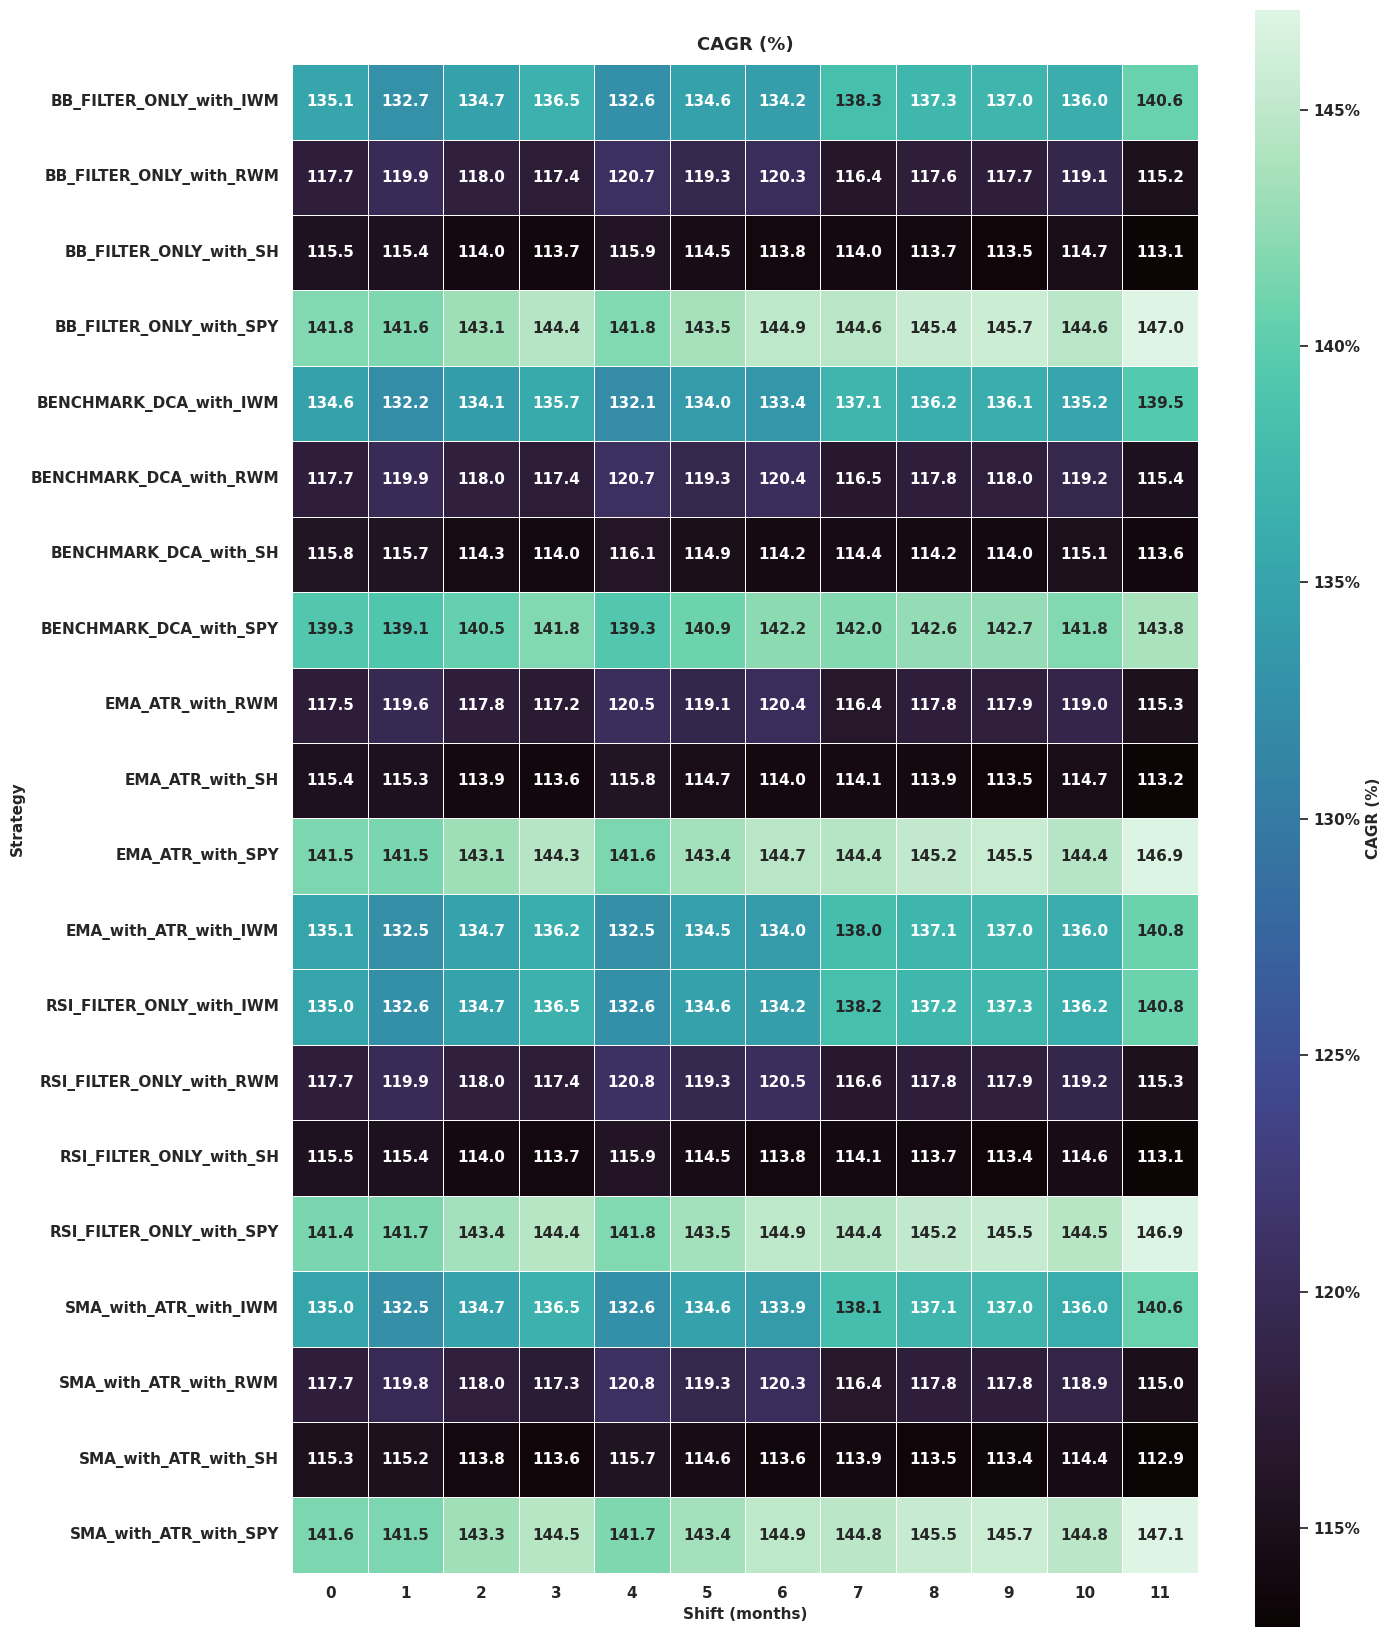

/tmp/ipython-input-3379667966.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


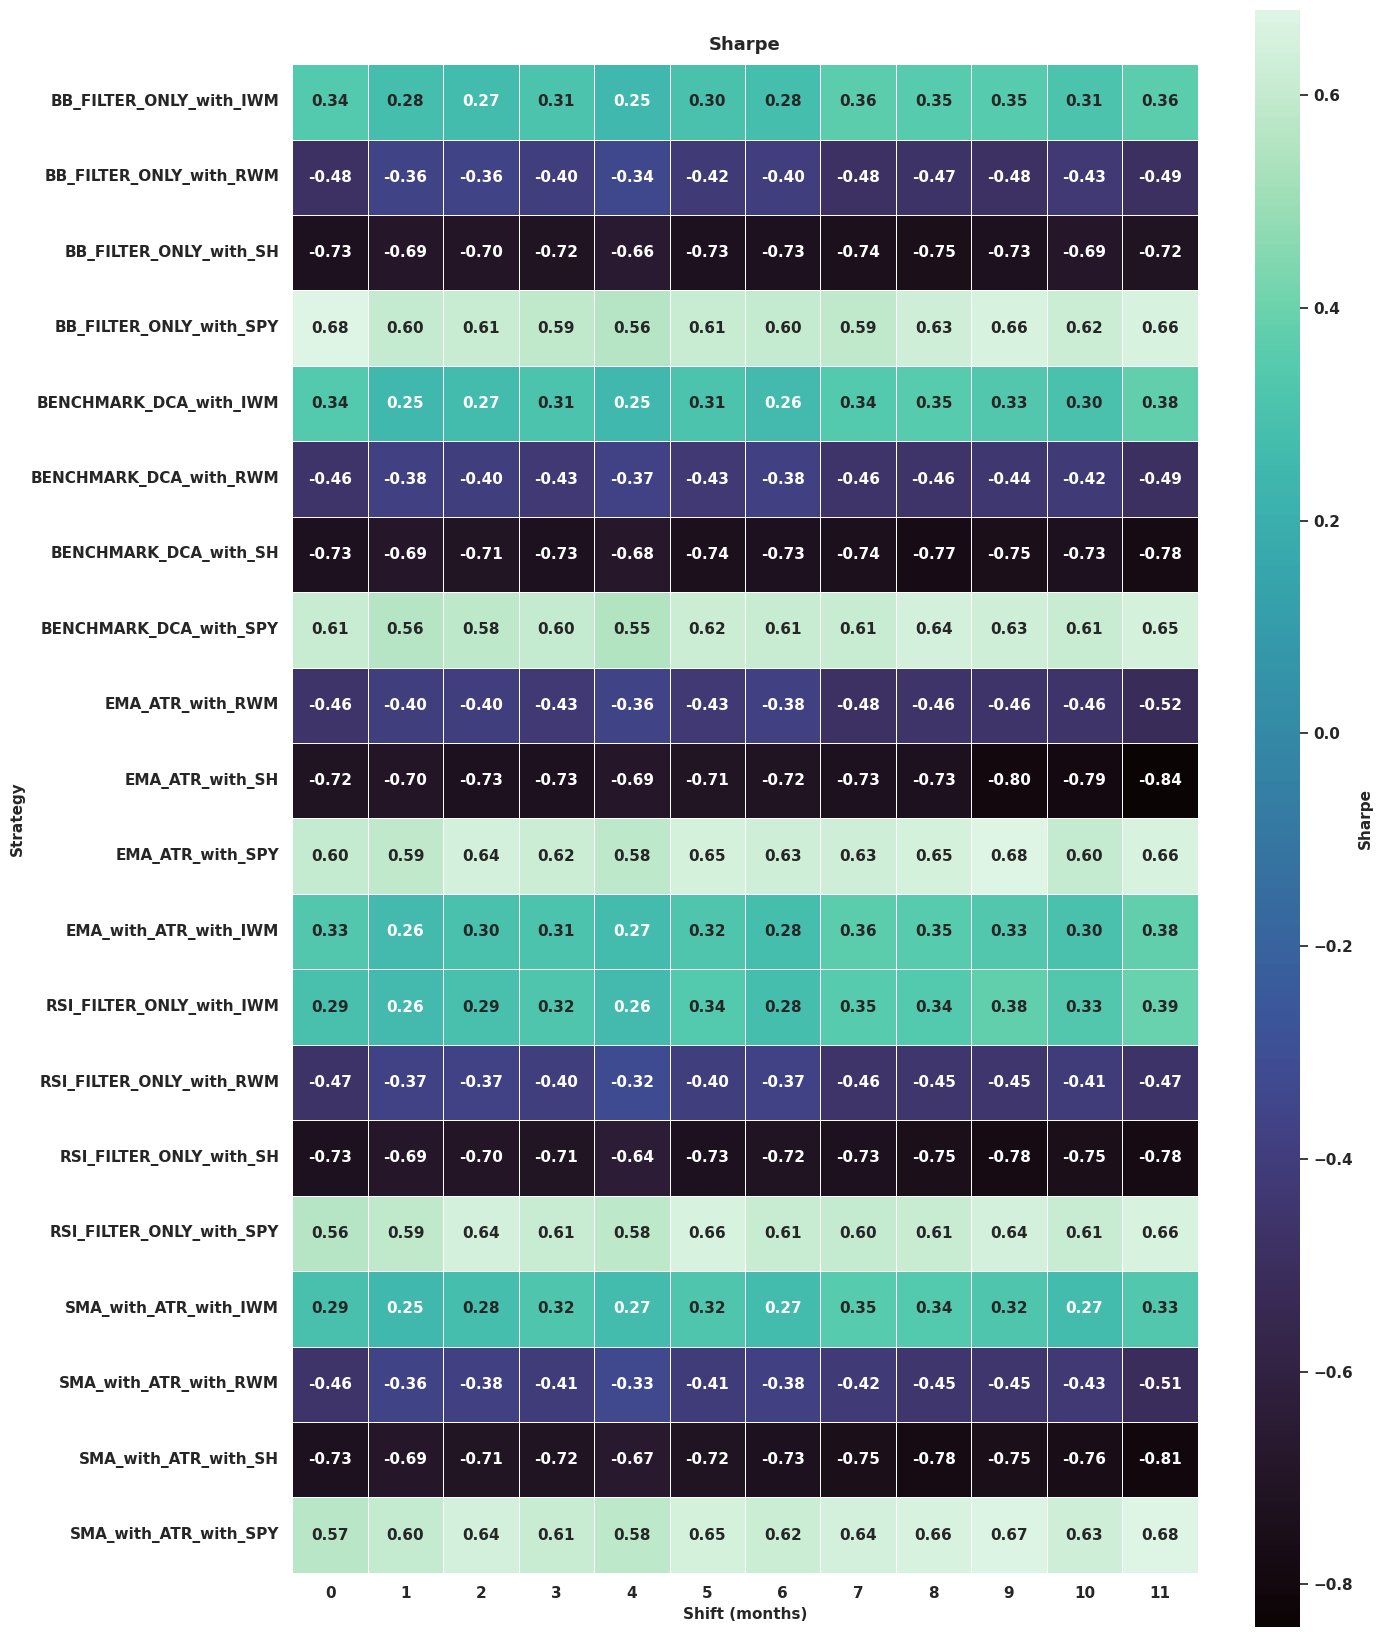

/tmp/ipython-input-3379667966.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


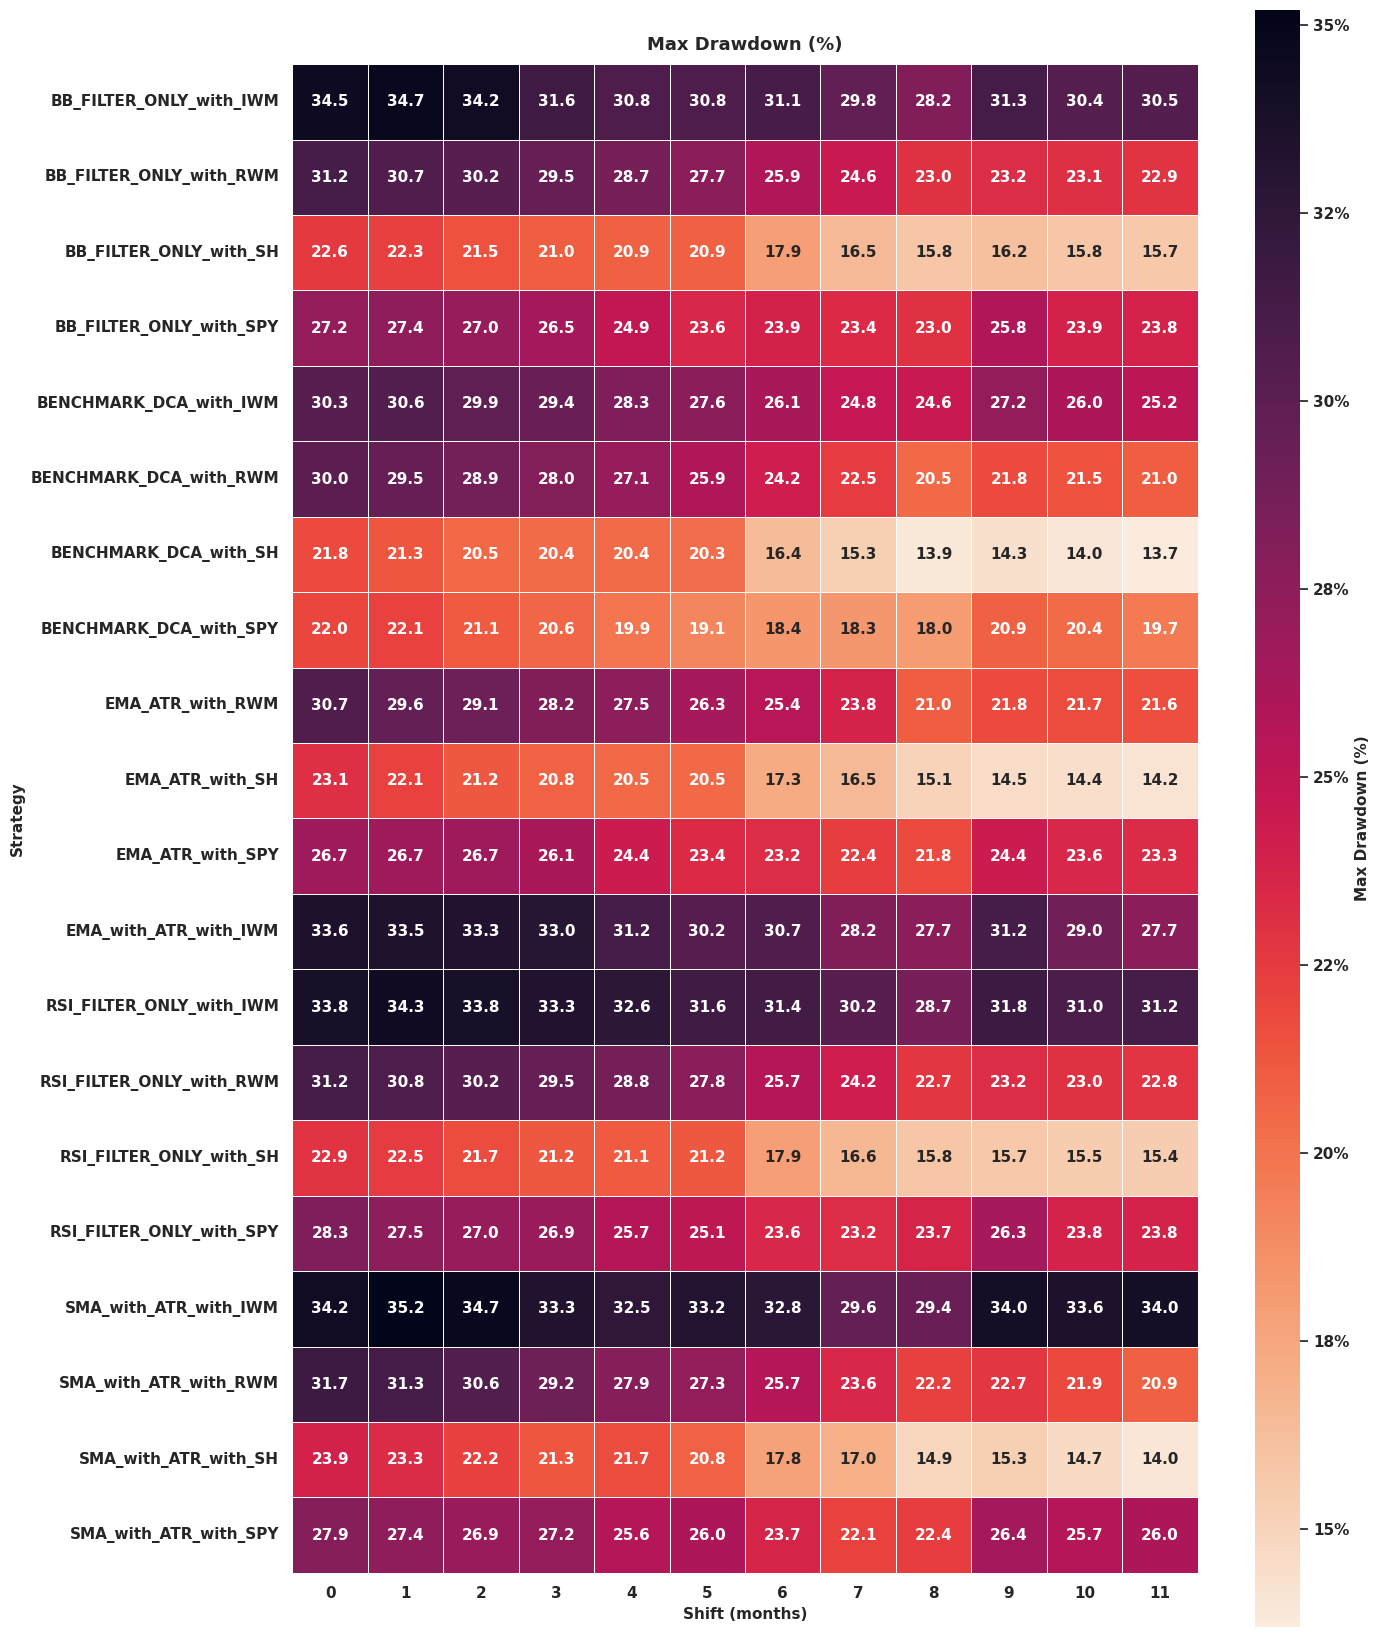

In [ ]:
# config
CSV_HEATMAPS = {
    "CAGR (%)": "cagr.csv",
    "Sharpe": "sharpe.csv",
    "Max Drawdown (%)": "drawdown.csv",
}
BASE_FONTSIZE = 11

# minimal, modern seaborn style (now with global bold)
SEABORN_THEME_OVERRIDES = {
    "font.size": BASE_FONTSIZE,
    "axes.titlesize": BASE_FONTSIZE + 2,
    "axes.labelsize": BASE_FONTSIZE,
    "xtick.labelsize": BASE_FONTSIZE,
    "ytick.labelsize": BASE_FONTSIZE,
    "font.weight": "bold",  # <- global bold
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
}
sns.set_theme(
    context="notebook",
    style="white",
    **{"rc": SEABORN_THEME_OVERRIDES},
)

# unified chart options
ANNOT_KWS = {
    "size": BASE_FONTSIZE,
    "weight": "bold",
    "ha": "center",
    "va": "center",
}
LINEWIDTHS = 0.6  # thin grid lines for readability
CBAR_ASPECT = 25  # slim colorbar
CELL_INCH = 1  # controls overall size via number of rows/cols
PAD_INCH = 1.0  # outer padding

# optional: per-metric colormaps (feel free to change)
CMAPS = {
    "CAGR (%)": "mako",
    "Sharpe": "mako",
    "Max Drawdown (%)": "rocket_r",  # lower (less drawdown) looks lighter
}


# helpers
def _sort_columns_if_numeric(dataframe: pd.DataFrame) -> pd.DataFrame:
    try:
        column_index = pd.Index(
            dataframe.columns,
            name=dataframe.columns.name,
        )
        numeric_index = pd.to_numeric(column_index, errors="raise")
        sorted_positions = numeric_index.argsort()
        return dataframe.iloc[:, sorted_positions]
    except Exception:
        return dataframe  # leave as-is if not all-numeric


def _fmt_for_metric(metric_title: str):
    # percentages to 1 decimal; others to 2 decimals
    if "%" in metric_title:
        return ".1f"
    return ".2f"


def _maybe_percent_formatter(metric_title: str):
    if "%" in metric_title:
        return FuncFormatter(lambda value, _unused_position: f"{value:.0f}%")
    return None


def _figure_size(row_count: int, column_count: int):
    return (
        PAD_INCH + CELL_INCH * max(column_count, 2),
        PAD_INCH + CELL_INCH * max(row_count, 2),
    )


# main loop
for title, filename in CSV_HEATMAPS.items():
    csv_path = os.path.join(OUTPUT_DIR, filename)
    if not os.path.exists(csv_path):
        print(f"Skipping {filename}: file not found at {csv_path}.")
        continue

    frame = pd.read_csv(csv_path)
    if "base_name" not in frame.columns:
        print(f"Skipping {filename}: missing 'base_name' column.")
        continue

    chart_data = (
        frame.set_index("base_name")
        .apply(pd.to_numeric, errors="coerce")
        .pipe(_sort_columns_if_numeric)
    )

    # mask NaNs so we don't annotate them
    nan_mask = chart_data.isna()

    # figure sizing for square cells
    row_count, column_count = chart_data.shape
    figure_width, figure_height = _figure_size(row_count, column_count)
    figure, (heatmap_ax, colorbar_ax) = plt.subplots(
        ncols=2,
        figsize=(figure_width, figure_height),
        gridspec_kw={
            "width_ratios": [1, 0.05],
            "wspace": 0.12,
        },  # slim, aligned cbar
    )

    color_map = CMAPS.get(title, "mako")
    display_format = _fmt_for_metric(title)

    # build heatmap
    heatmap = sns.heatmap(
        chart_data,
        mask=nan_mask,
        cmap=color_map,
        annot=True,
        fmt=display_format,
        annot_kws=ANNOT_KWS,  # bold annotations
        linewidths=LINEWIDTHS,  # keep thin lines (not zero)
        linecolor="white",
        square=True,  # keeps cells square
        cbar=True,
        cbar_kws={"label": title},  # label text set here; weight set below
        **{"ax": heatmap_ax, "cbar_ax": colorbar_ax},
    )

    # tidy axes (all bold)
    heatmap_ax.set_title(title, pad=10, weight="bold")
    heatmap_ax.set_xlabel("Shift (months)", weight="bold")
    heatmap_ax.set_ylabel("Strategy", weight="bold")
    heatmap_ax.tick_params(axis="x", labelrotation=0)
    heatmap_ax.tick_params(axis="y", labelrotation=0)
    for spine in heatmap_ax.spines.values():
        spine.set_visible(False)

    # make tick labels bold explicitly
    tick_labels = heatmap_ax.get_xticklabels() + heatmap_ax.get_yticklabels()
    for tick_label in tick_labels:
        tick_label.set_fontweight("bold")

    # colorbar: percent labels where applicable + bold label & ticks
    colorbar = heatmap.collections[0].colorbar if heatmap.collections else None
    if colorbar is not None:
        # ensure label is bold
        colorbar_axes = getattr(colorbar, "ax")
        colorbar_axes.yaxis.label.set_fontweight("bold")
        # ensure tick labels are bold
        for tick_label in colorbar_axes.get_yticklabels():
            tick_label.set_fontweight("bold")
        # optional percent formatter
        percent_formatter = _maybe_percent_formatter(title)
        if percent_formatter is not None:
            colorbar.formatter = percent_formatter
            colorbar.update_ticks()

    plt.tight_layout()
    plt.show()


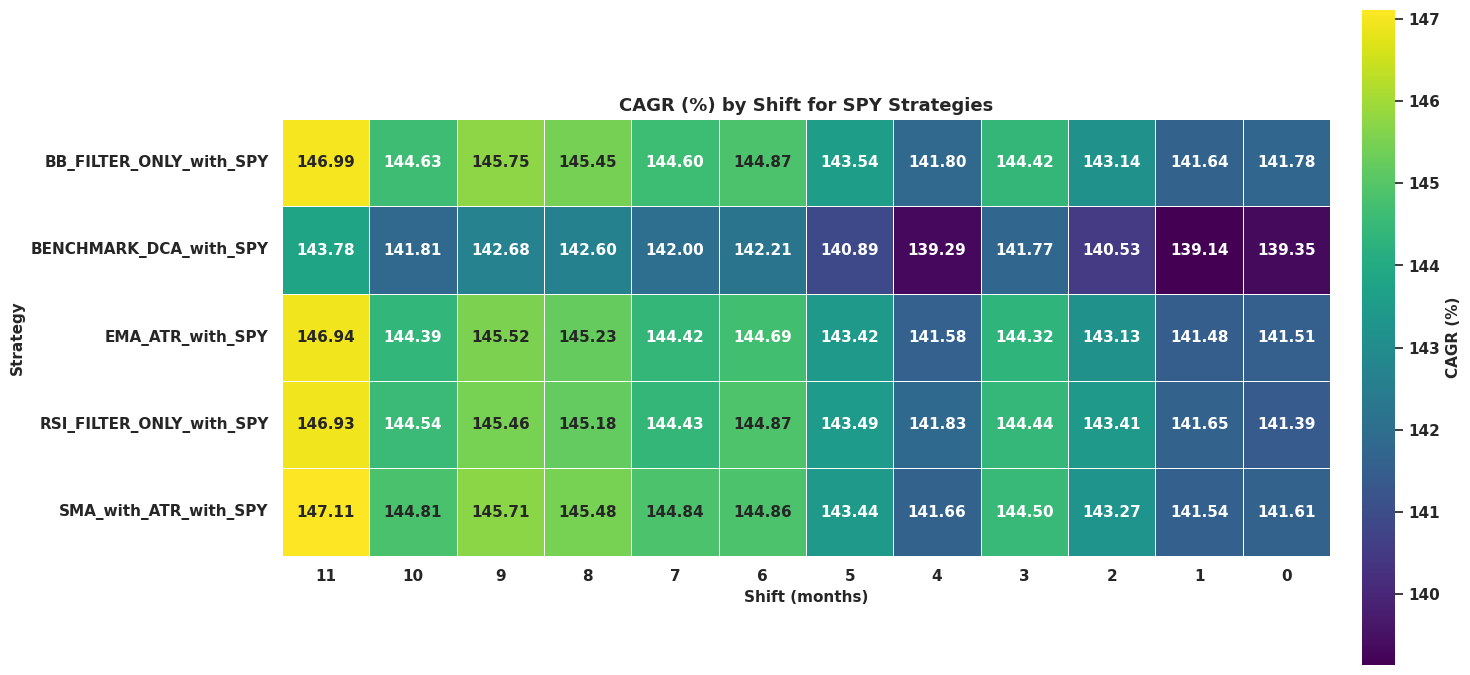

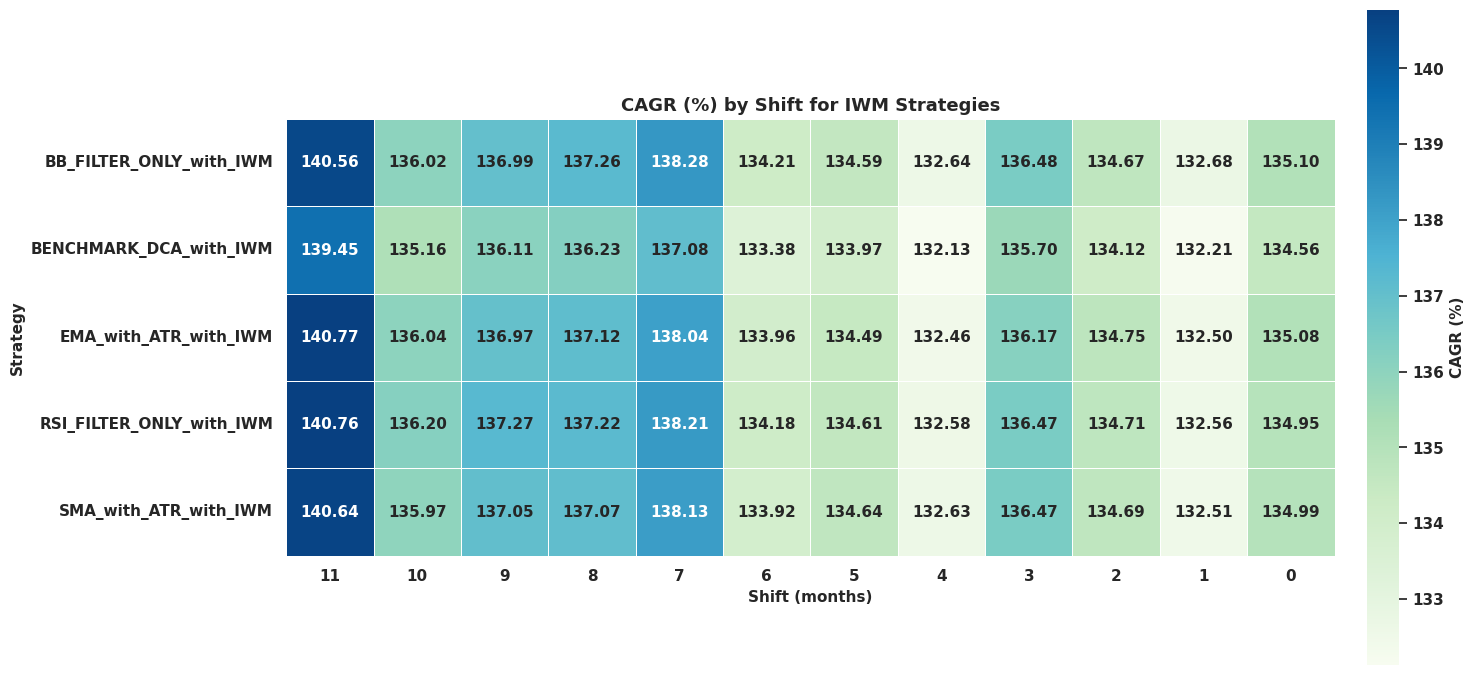

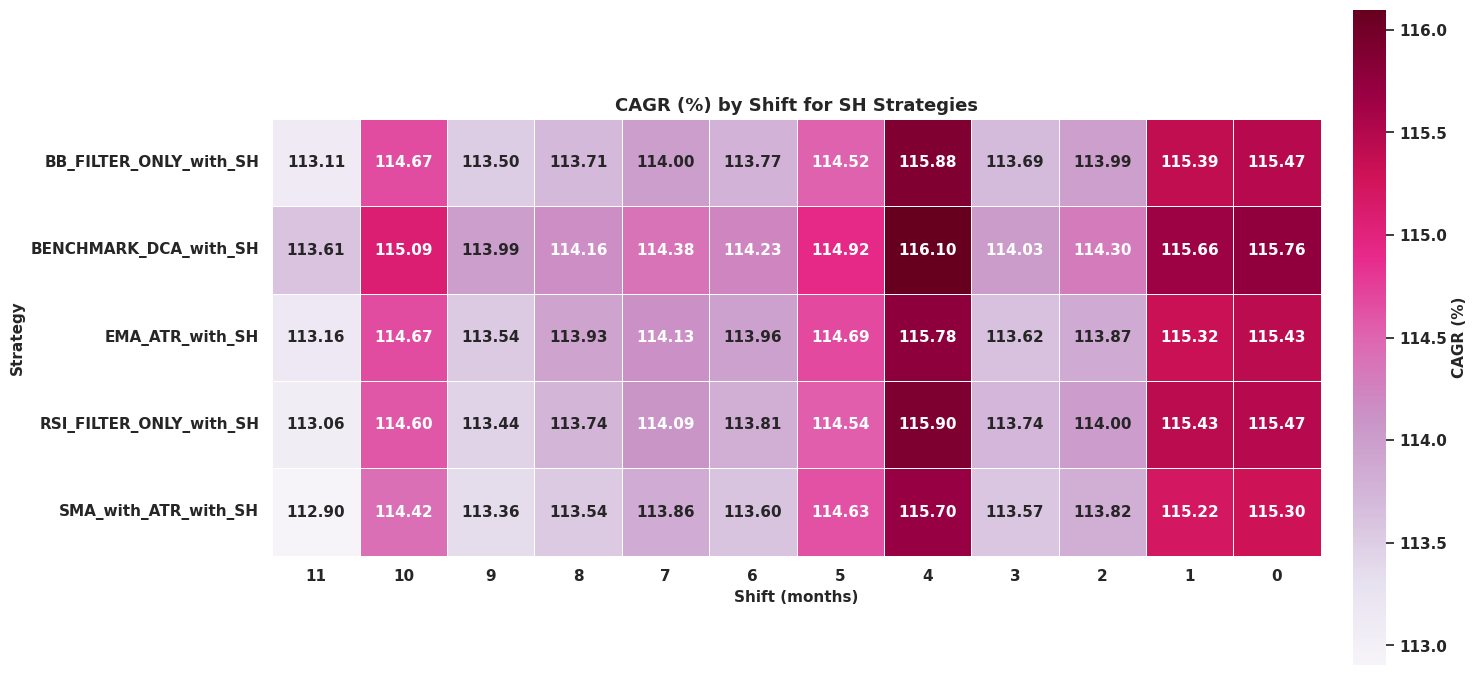

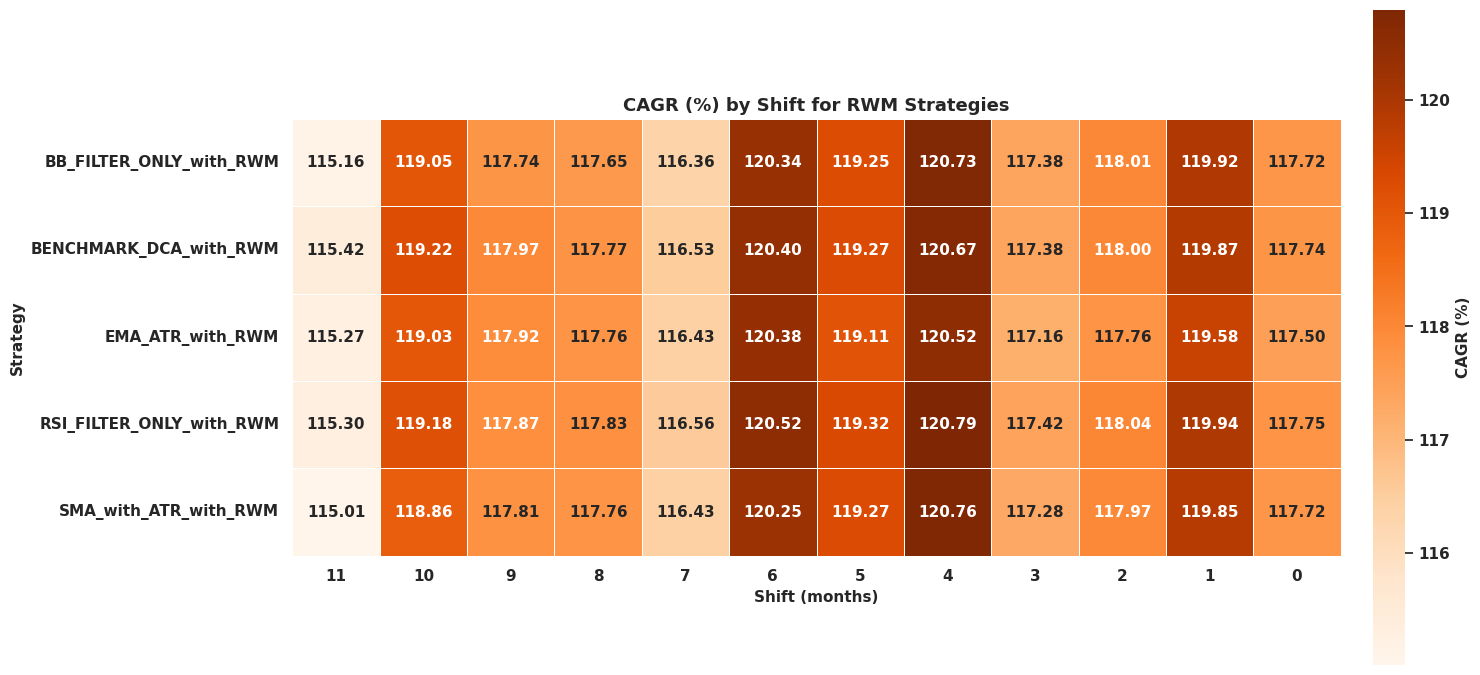

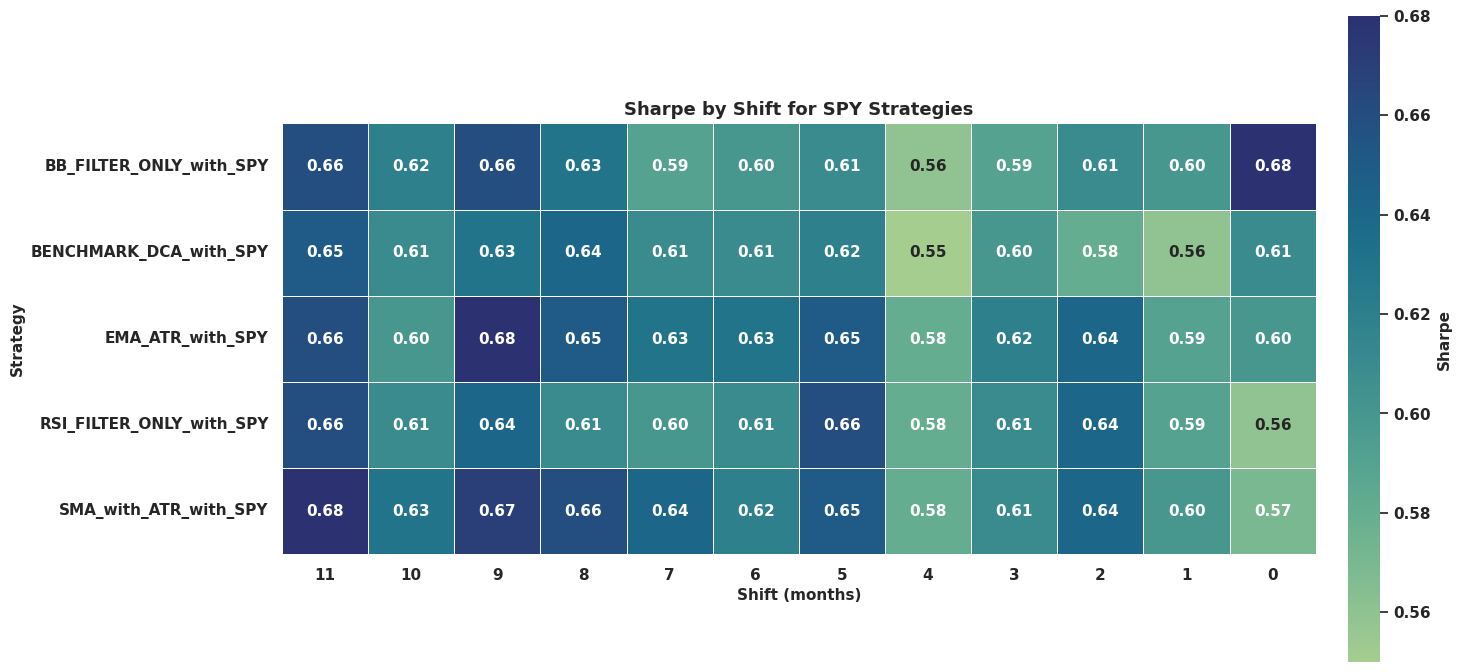

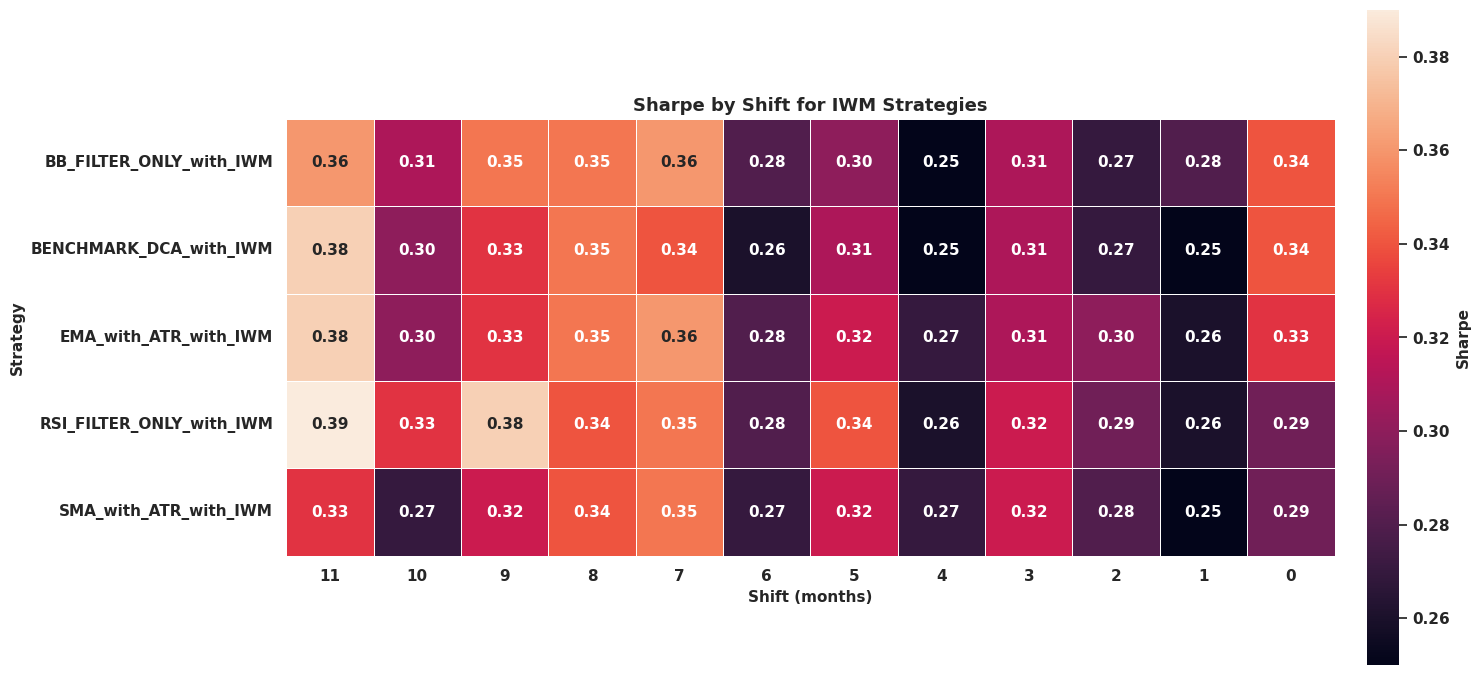

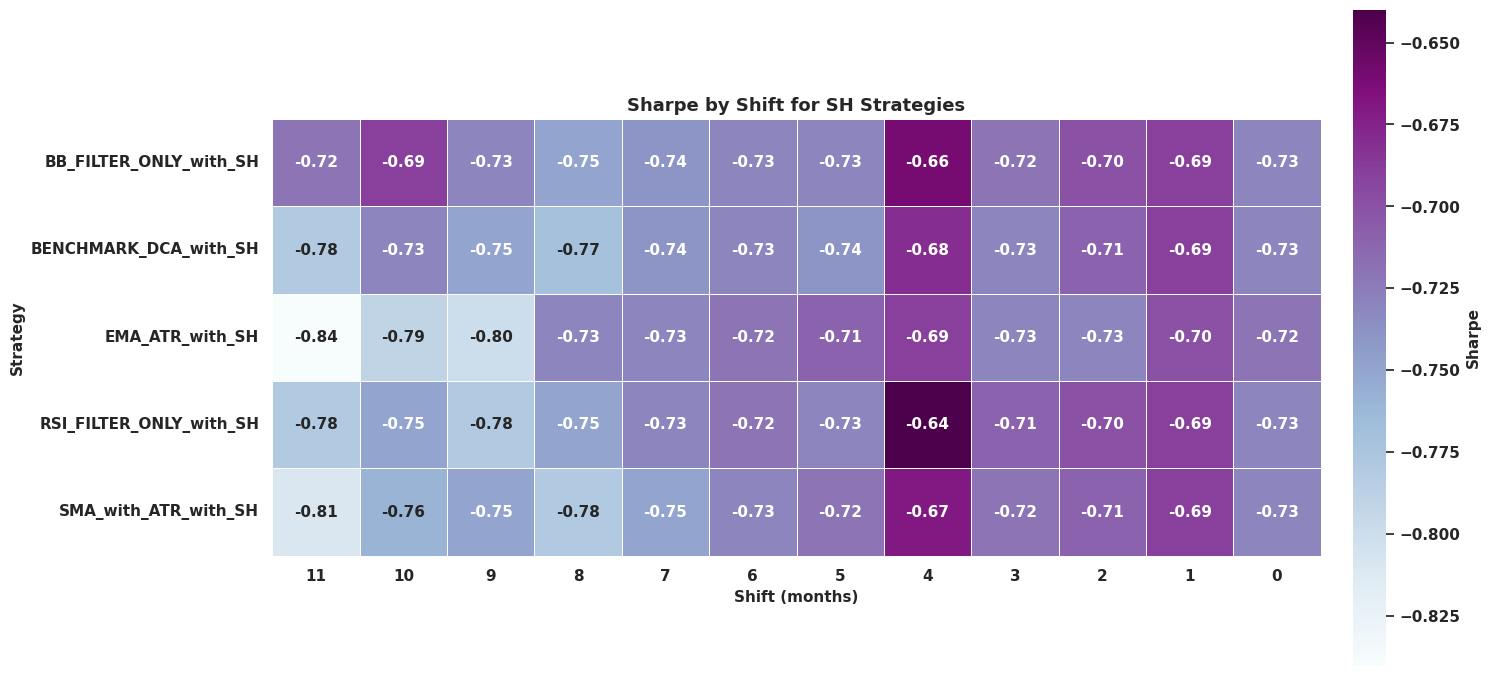

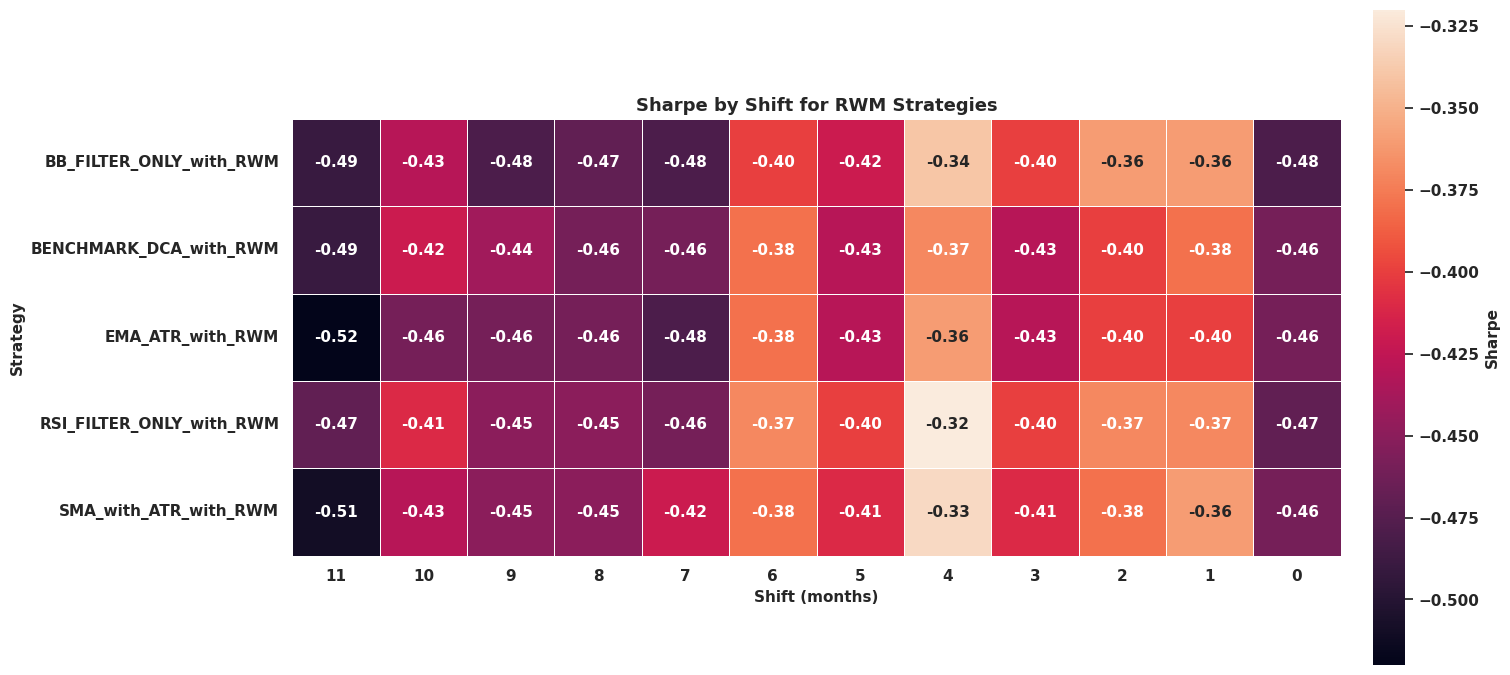

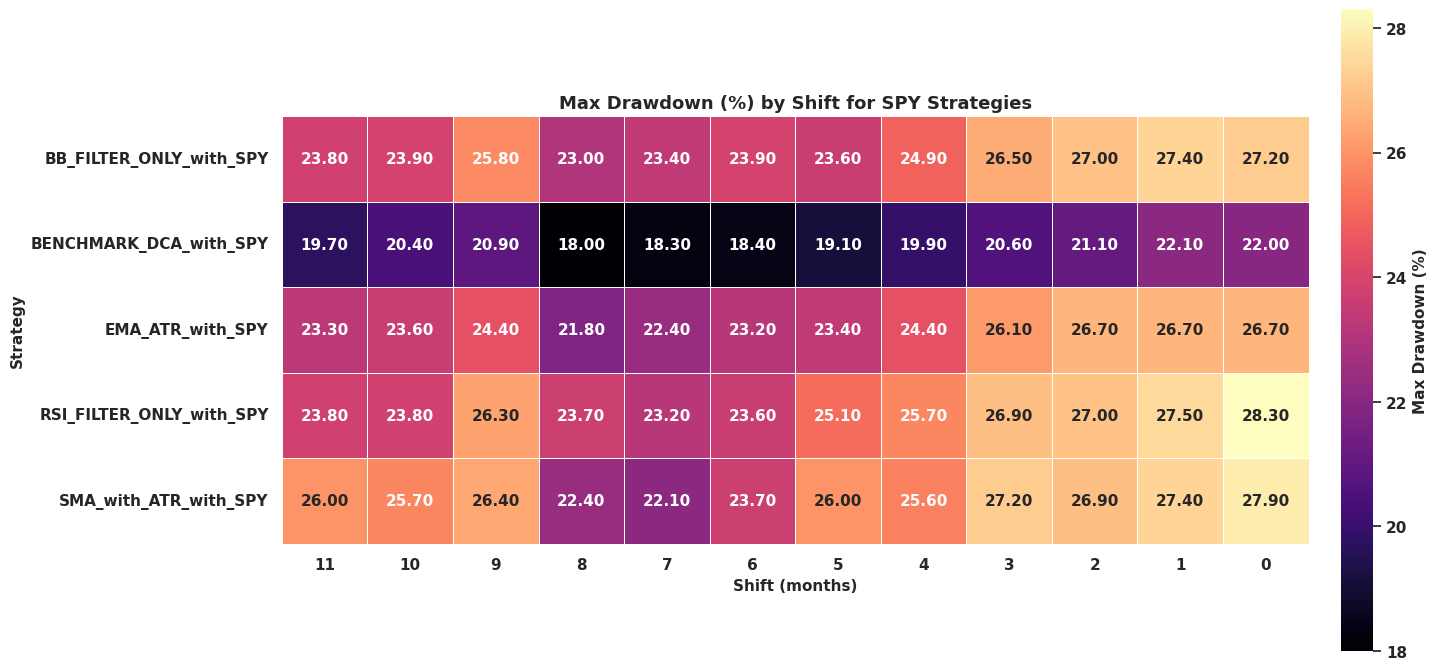

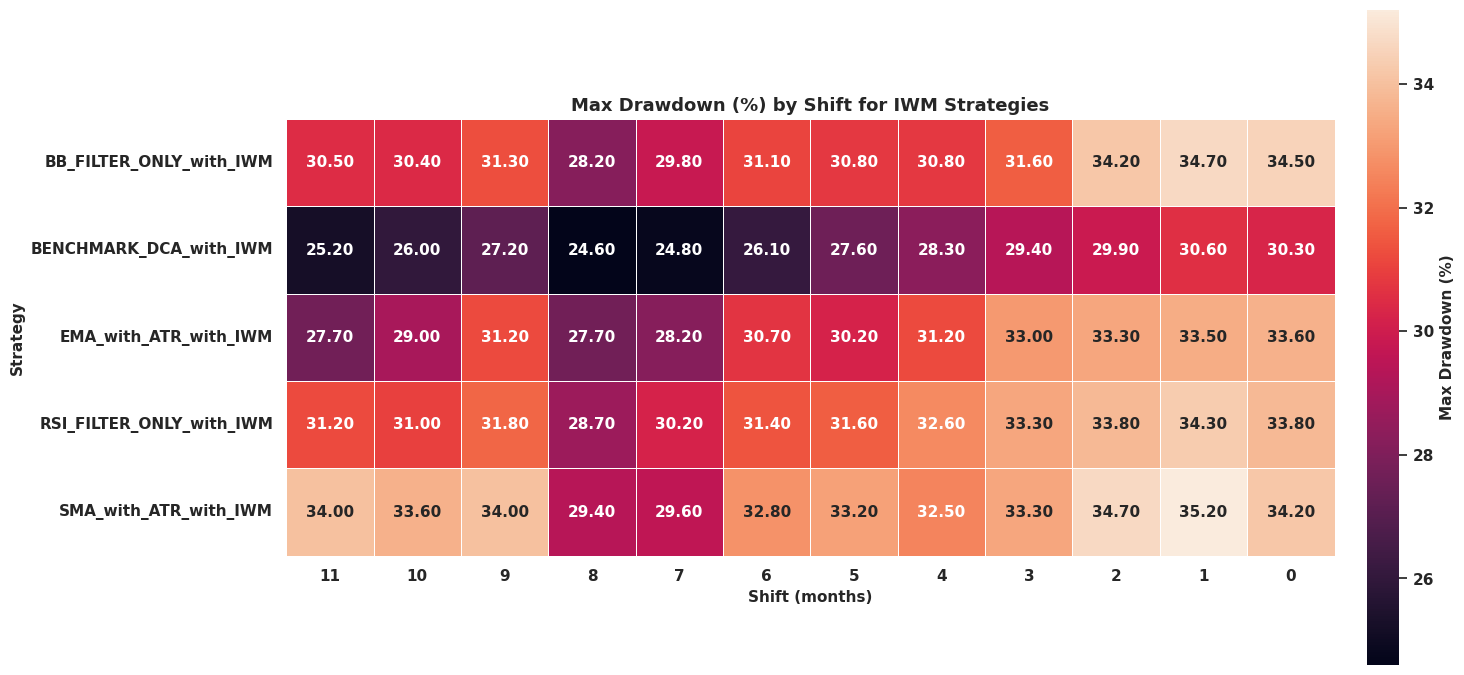

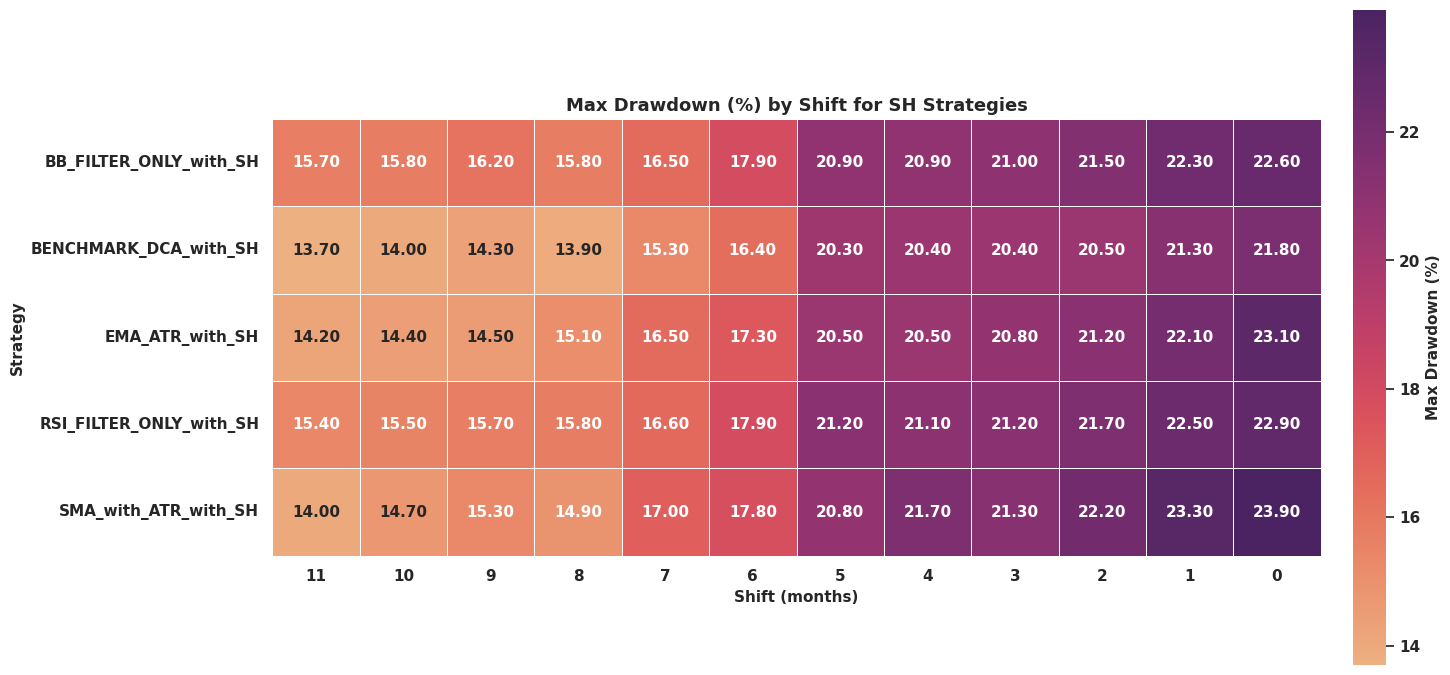

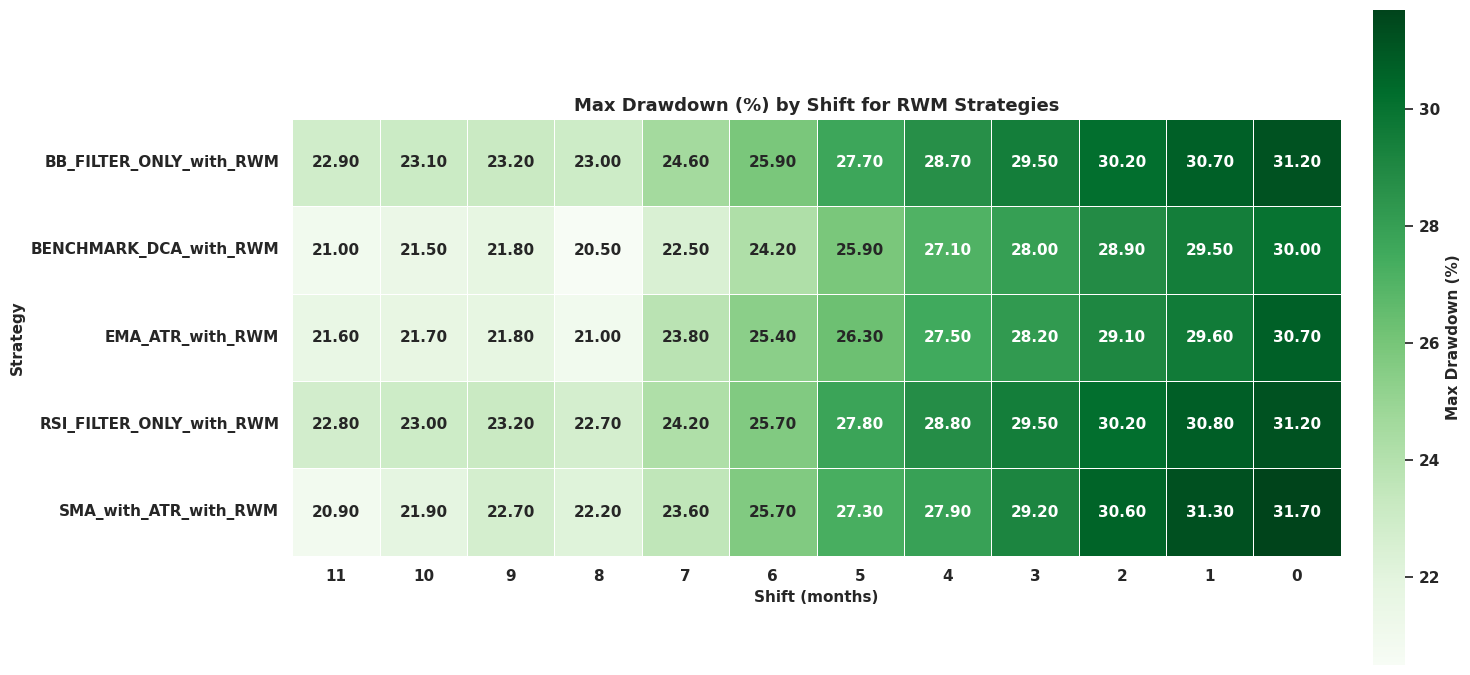

In [ ]:
# apply seaborn theme to match previous cell 
BASE_FONTSIZE = 11
SEABORN_THEME_OVERRIDES = {
    "font.size": BASE_FONTSIZE,
    "axes.titlesize": BASE_FONTSIZE + 2,
    "axes.labelsize": BASE_FONTSIZE,
    "xtick.labelsize": BASE_FONTSIZE,
    "ytick.labelsize": BASE_FONTSIZE,
    "font.weight": "bold",
    "axes.titleweight": "bold",
    "axes.labelweight": "bold",
}
sns.set_theme(
    context="notebook",
    style="white",
    **{"rc": SEABORN_THEME_OVERRIDES},
)

INDEX_LABELS = ["SPY", "IWM", "SH", "RWM"]
METRIC_FILES_INDEXED = {
    "CAGR (%)": "cagr.csv",
    "Sharpe": "sharpe.csv",
    "Max Drawdown (%)": "drawdown.csv",
}

# A palette of varied colormaps; we'll "randomly" pick one per (title,
# index_label), but in a deterministic way so it stays consistent across runs.
CMAPS = [
    "mako",
    "rocket",
    "crest",
    "viridis",
    "magma",
    "flare",
    "icefire",
    "cubehelix",
    "YlGnBu",
    "BuPu",
    "GnBu",
    "PuRd",
    "Oranges",
    "Greens",
    "Purples",
]

for title, filename in METRIC_FILES_INDEXED.items():
    csv_path = os.path.join(OUTPUT_DIR, filename)
    if not os.path.exists(csv_path):
        print(f"Skipping {title}: file not found at {csv_path}.")
        continue

    frame = pd.read_csv(csv_path)
    if "base_name" not in frame.columns:
        print(f"Skipping {title}: missing 'base_name' column.")
        continue

    for index_label in INDEX_LABELS:
        # match "..._with_TICKER" or "..._with_TICKER_..."
        pattern = rf"_with_{index_label}(?:_|$)"
        subset = frame[
            frame["base_name"].str.contains(
                pattern,
                regex=True,
                **{"na": False},
            )
        ].copy()
        if subset.empty:
            print(f"No rows for {index_label} in {filename}.")
            continue

        # Make numeric, drop fully non-numeric columns (after coercion).
        chart_data = subset.set_index("base_name").apply(
            pd.to_numeric, errors="coerce"
        )
        chart_data = chart_data.dropna(axis=1, how="all")
        if chart_data.empty or chart_data.isna().all().all():
            print(f"Only NaNs for {index_label} in {filename} after coercion.")
            continue

        row_count, column_count = chart_data.shape

        # Figure size chosen so cell shapes are square-ish; add small margin
        # for labels/colorbar.
        # Tweak for bigger/smaller cells while keeping existing font sizes.
        cell_size_inch = 1.5
        figure_width = (
            max(5.5, column_count * cell_size_inch) + 1.0
        )  # +1 for colorbar/labels
        figure_height = max(4.5, row_count * cell_size_inch)

        # Deterministic "random" colormap choice per (title, index_label)
        color_map_index = abs(hash((title, index_label))) % len(CMAPS)
        color_map = CMAPS[color_map_index]

        plt.figure(figsize=(figure_width, figure_height))
        heatmap_ax = sns.heatmap(
            chart_data,
            cmap=color_map,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            linecolor="white",
            square=True,  # square cells
            cbar_kws={"label": title, "shrink": 1.5, "pad": 0.02},
        )

        heatmap_ax.set_title(f"{title} by Shift for {index_label} Strategies")
        heatmap_ax.set_xlabel("Shift (months)")
        heatmap_ax.set_ylabel("Strategy")

        # Keep existing font sizes; just tidy up spacing/labels.
        heatmap_ax.tick_params(axis="x", labelrotation=0)
        heatmap_ax.tick_params(axis="y", labelrotation=0)

        # Seaborn-style polish consistent with previous cell
        # - bold titles/labels/ticks
        # - hide spines
        heatmap_ax.set_title(heatmap_ax.get_title(), weight="bold")
        heatmap_ax.set_xlabel(heatmap_ax.get_xlabel(), weight="bold")
        heatmap_ax.set_ylabel(heatmap_ax.get_ylabel(), weight="bold")
        for tick_label in (
            heatmap_ax.get_xticklabels() + heatmap_ax.get_yticklabels()
        ):
            tick_label.set_fontweight("bold")
        for spine in heatmap_ax.spines.values():
            spine.set_visible(False)
        # Make colorbar label and ticks bold if present
        colorbar = (
            heatmap_ax.collections[0].colorbar
            if hasattr(heatmap_ax, "collections") and heatmap_ax.collections
            else None
        )
        if colorbar is not None:
            colorbar_axes = getattr(colorbar, "ax")
            colorbar_axes.yaxis.label.set_fontweight("bold")
            for tick_label in colorbar_axes.get_yticklabels():
                tick_label.set_fontweight("bold")

        plt.tight_layout(pad=0.8)
        plt.show()
